In [1]:
pip uninstall tensorflow tensorflow-gpu keras -y

Note: you may need to restart the kernel to use updated packages.Found existing installation: tensorflow 2.10.0
Uninstalling tensorflow-2.10.0:
  Successfully uninstalled tensorflow-2.10.0
Found existing installation: keras 2.10.0
Uninstalling keras-2.10.0:
  Successfully uninstalled keras-2.10.0



In [2]:
pip install tensorflow==2.10.0

  Using cached tensorflow-2.10.0-cp39-cp39-win_amd64.whl.metadata (3.1 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.10.0-cp39-cp39-win_amd64.whl (455.9 MB)
Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.10.0 which is incompatible.
tensorflow-cpu 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.cm as cm

In [4]:
import shutil
import random

# Paths
original_dataset_dir = 'C:/minor project/wheat_project/Wheat'
base_dir = 'C:/minor project/wheat_project/dataset'  # New base folder where train/val/test will be created

# Create train/val/test directories
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    for category in ['Wheat___Healthy', 'Wheat___Brown_Rust', 'Wheat___Yellow_Rust']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Parameters
split_ratio = [0.8, 0.1, 0.1]  # 80% train, 10% val, 10% test

# For each category
for category in ['Wheat___Healthy', 'Wheat___Brown_Rust', 'Wheat___Yellow_Rust']:
    category_path = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)
    
    train_size = int(len(images) * split_ratio[0])
    val_size = int(len(images) * split_ratio[1])

    train_images = images[:train_size]
    val_images = images[train_size:train_size + val_size]
    test_images = images[train_size + val_size:]

    # Move images
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'train', category, img))
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'val', category, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'test', category, img))

print("✅ Data split complete!")


✅ Data split complete!


In [5]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

In [6]:
# Paths
train_dir = 'C:/minor project/wheat_project/dataset/train'
val_dir = 'C:/minor project/wheat_project/dataset/val'
test_dir = 'C:/minor project/wheat_project/dataset/test'


# 1. Data Augmentation for Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# 2. Data Preprocessing for Validation
val_datagen = ImageDataGenerator(rescale=1./255)

# 3. Data Preprocessing for Test
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Create Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2352 images belonging to 3 classes.
Found 293 images belonging to 3 classes.
Found 297 images belonging to 3 classes.


In [7]:
# Labels
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Counts
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

train_counts.index = [class_names[i] for i in train_counts.index]
val_counts.index = [class_names[i] for i in val_counts.index]
test_counts.index = [class_names[i] for i in test_counts.index]

print("\nTraining:")
print(train_counts)
print("\nValidation:")
print(val_counts)
print("\nTesting:")
print(test_counts)



Training:
Wheat___Brown_Rust     721
Wheat___Healthy        892
Wheat___Yellow_Rust    739
Name: count, dtype: int64

Validation:
Wheat___Brown_Rust      90
Wheat___Healthy        111
Wheat___Yellow_Rust     92
Name: count, dtype: int64

Testing:
Wheat___Brown_Rust      91
Wheat___Healthy        113
Wheat___Yellow_Rust     93
Name: count, dtype: int64


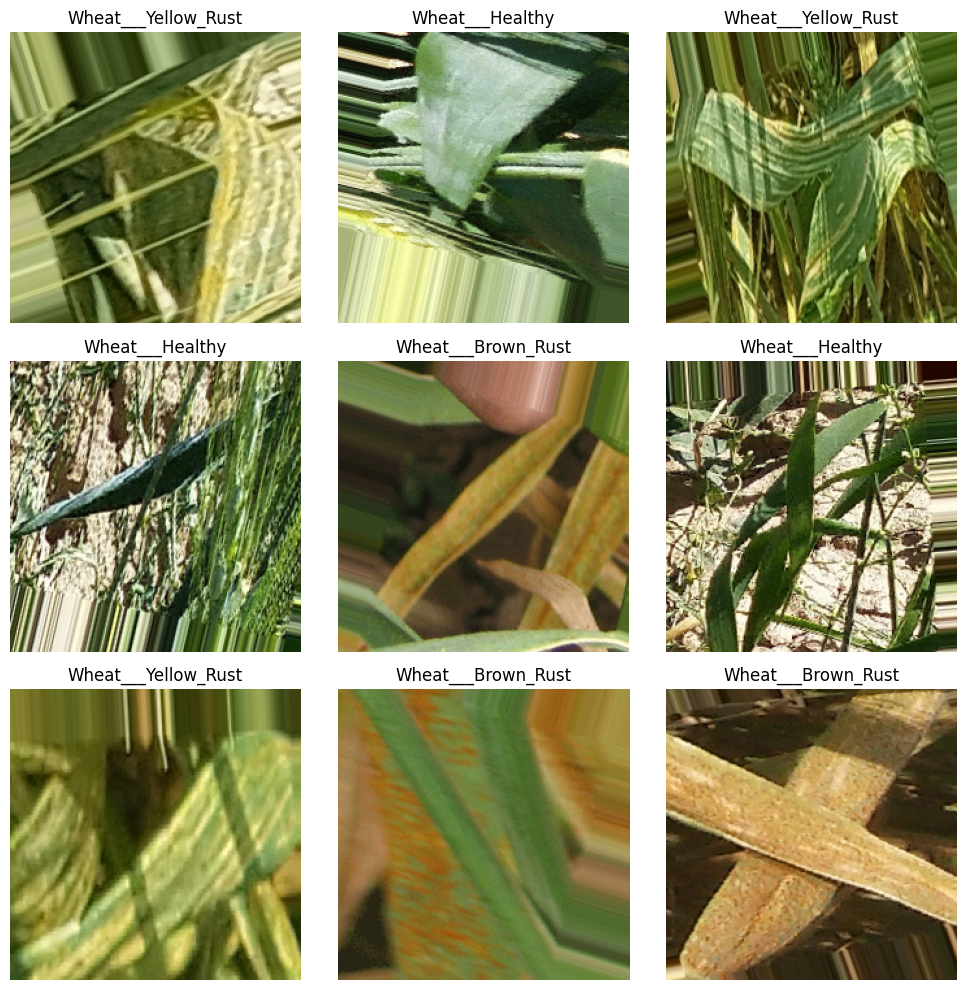

In [8]:
# Visualize training images
def show_images(generator, class_names, num_images=9):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train_generator, class_names)

In [9]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

hybrid_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hybrid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-tr

In [10]:
hybrid_history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
74/74 [==============================] - 90s 1s/step - loss: 0.4538 - accuracy: 0.8227 - val_loss: 0.1915 - val_accuracy: 0.9283
Epoch 2/10
74/74 [==============================] - 64s 863ms/step - loss: 0.1743 - accuracy: 0.9422 - val_loss: 0.1256 - val_accuracy: 0.9454
Epoch 3/10
74/74 [==============================] - 65s 874ms/step - loss: 0.1338 - accuracy: 0.9486 - val_loss: 0.1405 - val_accuracy: 0.9522
Epoch 4/10
74/74 [==============================] - 65s 872ms/step - loss: 0.1131 - accuracy: 0.9588 - val_loss: 0.1029 - val_accuracy: 0.9659
Epoch 5/10
74/74 [==============================] - 65s 881ms/step - loss: 0.1141 - accuracy: 0.9600 - val_loss: 0.0985 - val_accuracy: 0.9590
Epoch 6/10
74/74 [==============================] - 64s 862ms/step - loss: 0.0927 - accuracy: 0.9673 - val_loss: 0.1050 - val_accuracy: 0.9727
Epoch 7/10
74/74 [==============================] - 67s 902ms/step - loss: 0.0872 - accuracy: 0.9694 - val_loss: 0.0999 - val_accuracy: 0.9659
Ep

In [11]:
# Plot accuracy and loss
def plot_performance(history, model_name):
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.show()

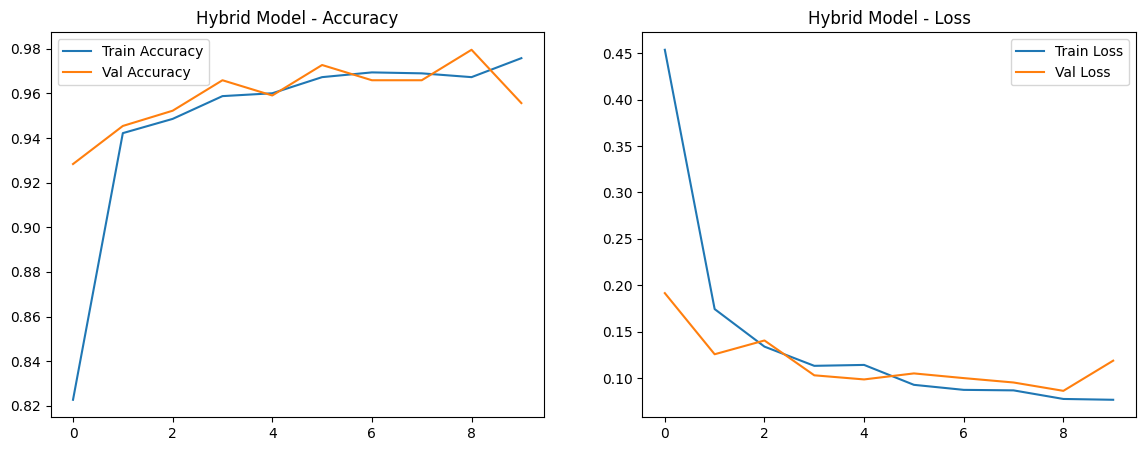

In [12]:
plot_performance(hybrid_history, "Hybrid Model")

In [13]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report

# Function to evaluate model and generate classification report
def evaluate_model(model, test_dir):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
    
    # Get predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Classification Report
    report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
    return report



# Evaluate CNN-Transformer Model
hybrid_report = evaluate_model(hybrid_model, 'dataset/test')
print("CNN-MobileNetV2 Hybrid Model Classification Report:")
print(hybrid_report)

Found 297 images belonging to 3 classes.
10/10 [==============================] - 13s 1s/step
CNN-MobileNetV2 Hybrid Model Classification Report:
                     precision    recall  f1-score   support

 Wheat___Brown_Rust       0.94      0.98      0.96        91
    Wheat___Healthy       0.97      1.00      0.99       113
Wheat___Yellow_Rust       1.00      0.92      0.96        93

           accuracy                           0.97       297
          macro avg       0.97      0.97      0.97       297
       weighted avg       0.97      0.97      0.97       297



In [14]:
def predict_image(model, img_path, class_names):
   
    # 1. Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # 2. Model prediction
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])
    predicted_class = class_names[pred_idx]
    confidence = preds[0][pred_idx] * 100
    
    # 3. Extract actual class from the folder name
    actual_class = os.path.basename(os.path.dirname(img_path))
    
    # 4. Print results
    print(f"Actual Class:    {actual_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence:      {confidence:.2f}%")
    
    # 5. Display the image with both labels
    plt.imshow(img)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 122ms/step
Actual Class:    Wheat___Brown_Rust
Predicted Class: Wheat___Brown_Rust
Confidence:      100.00%


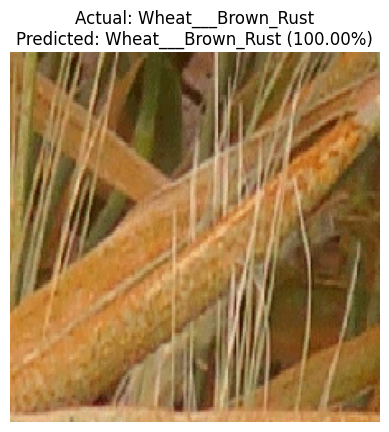

1/1 [==============================] - 0s 119ms/step
Actual Class:    Wheat___Brown_Rust
Predicted Class: Wheat___Brown_Rust
Confidence:      99.98%


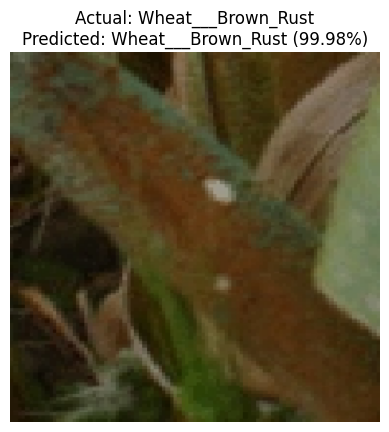

1/1 [==============================] - 0s 117ms/step
Actual Class:    Wheat___Yellow_Rust
Predicted Class: Wheat___Brown_Rust
Confidence:      68.20%


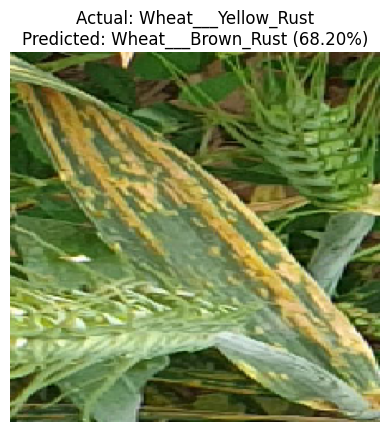

1/1 [==============================] - 0s 106ms/step
Actual Class:    Wheat___Brown_Rust
Predicted Class: Wheat___Brown_Rust
Confidence:      99.52%


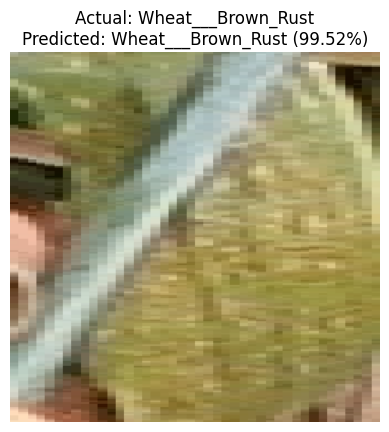

1/1 [==============================] - 0s 95ms/step
Actual Class:    Wheat___Healthy
Predicted Class: Wheat___Healthy
Confidence:      99.96%


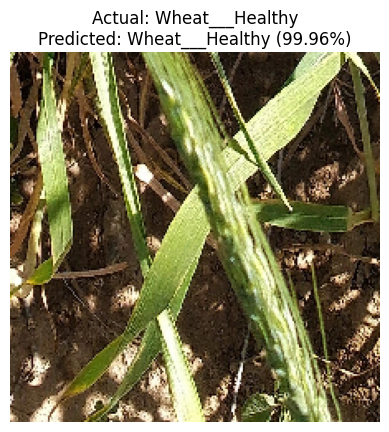

1/1 [==============================] - 0s 110ms/step
Actual Class:    Wheat___Brown_Rust
Predicted Class: Wheat___Brown_Rust
Confidence:      99.69%


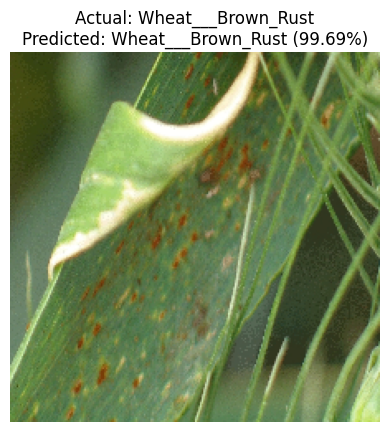

In [24]:
import random
# Define the path to the test dataset directory
test_directory = "dataset/test"

# List all the images in the directory and its subdirectories
all_images = []
for root, dirs, files in os.walk(test_directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure you only include image files
            all_images.append(os.path.join(root, file))

# Pick a random image
for _ in range(6):
    random_img_path = random.choice(all_images)
    predict_image(hybrid_model, random_img_path, class_names)